In [24]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import glob
import json
import pybt
from pybt.tools.parsers import read_twiss_file
from pybt.myjson.encoder import myJSONDecoder
from os import walk
import matplotlib.dates as mdates
import pickle
from datetime import datetime
from scipy.optimize import curve_fit
import jpype
jpype.startJVM(jpype.getDefaultJVMPath())

OSError: JVM is already started

In [25]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def beam_size(beta, dispersion, eps, dpp, n):
    """
    Simple calculation of beam size
    """
    beam = np.sqrt(eps*beta + (dpp*dispersion)**2)
    return beam*n

def interpolate_gradient(current, magnet_type):
	A_Q74L = [5.000978,
			  10.000304,
			  50.002003,
			  100.001404,
			  150.001373,
			  200.00238,
			  250.005432,
			  299.993652,
			  350.001648,
			  399.995728,
			  449.994446,
			  499.997375,
			  549.999878,
			  599.994873,
			  650.004211,
			  666.999146,
			  699.991455,
			  749.998169,
			  799.996643]

	T_Q74L = [0.2619,
			  0.492968,
			  2.358847,
			  4.710821,
			  7.068205,
			  9.426532,
			  11.780794,
			  14.131984,
			  16.4773,
			  18.814776,
			  21.133094,
			  23.416058,
			  25.617934,
			  27.638804,
			  29.43015,
			  29.981004,
			  30.987122,
			  32.347211,
			  33.545971]

	A_Q120C = [0.00,
			   50.00,
			   100.00,
			   150.00,
			   200.00,
			   250.00,
			   300.00,
			   350.00,
			   400.00,
			   450.00,
			   500.00,
			   550.00,
			   600.00,
			   650.00]

	T_Q120C = [0.00,
			   2.05,
			   4.12,
			   6.19,
			   8.26,
			   10.33,
			   12.39,
			   14.43,
			   16.44,
			   18.36,
			   20.14,
			   21.74,
			   23.01,
			   24.07]

	A_QFL = [0,
			 94.15,
			 145.76,
			 197.97,
			 250.74,
			 300.18,
			 350.7,
			 402,
			 451.15,
			 502.09,
			 551.47]

	T_QFL = [0,
			 4.86,
			 7.48,
			 10.158,
			 12.875,
			 15.377,
			 17.81,
			 20.045,
			 21.844,
			 23.217,
			 24.445]

	if magnet_type == "Q74L":
		measured_currents = A_Q74L
		measured_int_gradient = T_Q74L
	if magnet_type == "Q120C":
		measured_currents = A_Q120C
		measured_int_gradient = T_Q120C
	if magnet_type == "QFL":
		measured_currents = A_QFL
		measured_int_gradient = T_QFL

	# Make the curve symmetric
	if (current < 0):
		interpolated_int_gradient = -np.interp(-current, measured_currents, measured_int_gradient)
	else:
		interpolated_int_gradient = np.interp(current, measured_currents, measured_int_gradient)

	return interpolated_int_gradient

In [26]:
header_read, twiss_read = read_twiss_file('/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/east-fast-extraction/tfs/fast_extraction.twiss')
gamma = header_read["gamma"]
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread
Brho = 24*3.3356

quad_current = {
    "QFN01": 620,
    "QDN02": 404,
    "QFN03": 378,
}
quad_length = {
    "QFN01": 0.74,
    "QDN02": 1.2,
    "QFN03": 1.2,
}

In [9]:
6.71284503e+01  1.36754312e+01 -2.52941869e+01 -1.14540714e-01
 -4.27105299e+00 -5.64842234e-02 -1.07753798e+00 -2.28911465e-01
  4.04224188e-07  1.74604842e-06  8.48915852e-04

SyntaxError: invalid syntax (3334332672.py, line 1)

In [21]:
# Initial conditions East Area
betx00 = 82.4
bety00 = 33.2
alfx00 = -11.1
alfy00 = 0.28
Dx00 = 0.13
Dy00 = 0.0
Dpx00 = 0.02
Dpy00 = 0
exn0 = 4.04224188e-07
eyn0 = 1.74604842e-06
sige0 = 8.48915852e-04

In [ ]:
5.39892074e+01  1.35513961e+01 -5.88728165e+01 -5.81817138e-01
 -2.34781194e+00  7.92192452e-02 -6.13219015e-01 -1.25332747e-01
  1.08652778e-08  1.74462238e-06  1.51466024e-03

In [54]:
# New initial conditions East Area
betx0 = 5.39892074e+01
bety0 = 1.35513961e+01
alfx0 = -5.88728165e+01
alfy0 = -5.81817138e-01
Dx0 = -2.34781194e+00
Dy0 = 7.92192452e-02
Dpx0 = -6.13219015e-01
Dpy0 = -1.25332747e-01
exn = 1.08652778e-08
eyn = 1.74462238e-06
sige = 1.51466024e-03

In [41]:
filename_list = ["quad_scan_east_dump_2022_04_11_13h17m30s","quad_scan_east_dump_2022_04_11_13h47m05s", "quad_scan_east_dump_2022_04_11_14h28m24s", "quad_scan_east_dump_2022_04_11_14h44m15s", "quad_scan_east_dump_2022_04_11_15h03m36s"]

In [42]:
# Create an empty df
master_df_H = pd.DataFrame()
master_df_V = pd.DataFrame()

# First data measurement

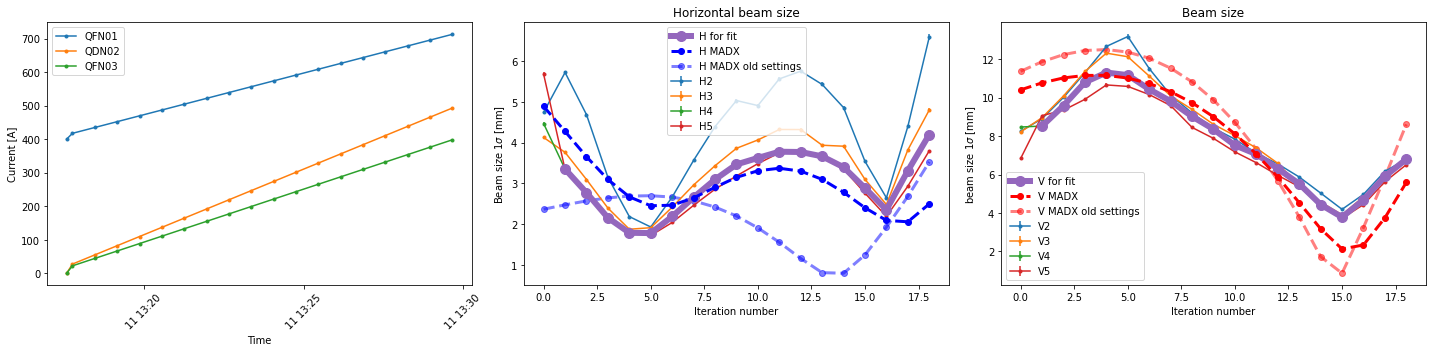

In [43]:
start_path = "/afs/cern.ch/user/e/eljohnso/Desktop/quad-scan-east"
end_path = "quad_scan_east_dump_data"
filename = filename_list[0]


infile = open(end_path+"/"+filename+"/"+filename+".p", 'rb')
loaded_pickle = pickle.load(infile)

timestamp_list = loaded_pickle[0]

acquisition = loaded_pickle[1]["F61D.BTV010/Acquisition"]
    
fig, ax = plt.subplots(1,3, figsize = (20,5), tight_layout=True)

###### PLOT CURRENT ######

qfn01_current = loaded_pickle[3]['F61.QFN01/MEAS.PULSE#VALUE']
qdn02_current = loaded_pickle[3]['F61.QDN02/MEAS.PULSE#VALUE']
qfn03_current = loaded_pickle[3]['F61.QFN03/MEAS.PULSE#VALUE']

ax[0].plot(timestamp_list, qfn01_current, marker = "o", markersize=3, label = "QFN01")
ax[0].plot(timestamp_list, qdn02_current, marker = "o", markersize=3, label = "QDN02")
ax[0].plot(timestamp_list, qfn03_current, marker = "o", markersize=3, label = "QFN03")

ax[0].tick_params('x', labelrotation=45)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Current [A]")
ax[0].legend()

###### SELECT HORIZONTAL DATA ######
range_shots = [1,len(acquisition)]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))

H_sigma_list = []

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)
    
    ax[1].errorbar(x_axis, H_sigma_list_i, yerr = H_err_sigma_list_i, marker = "o", markersize=3, label = f"H{acq_number}")
    
    H_sigma_list.append(H_sigma_list_i)
   


d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_H': H_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_H = pd.DataFrame(data=d)
master_df_H = master_df_H.append(df_H, ignore_index=True)

ax[1].plot(x_axis[range_shots[0]:range_shots[1]:], df_H.sigma_H, marker="o", markersize=10, linewidth=6, label = f"H for fit", zorder=99)
ax[1].set_xlabel("Iteration number")
ax[1].set_ylabel(f"Beam size 1$\sigma$ [mm]")
ax[1].set_title("Horizontal beam size")

###### SELECT VERTICAL DATA ######
range_shots = [1,len(acquisition)]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))


V_sigma_list = []

for acq_number in [2,3,4,5]:

    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)
    
    ax[2].errorbar(x_axis, V_sigma_list_i, yerr = V_err_sigma_list_i, marker = "o", markersize=3, label = f"V{acq_number}")
       
    V_sigma_list.append(V_sigma_list_i)
   
d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_V': V_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_V = pd.DataFrame(data=d)
master_df_V = master_df_V.append(df_V, ignore_index=True)

ax[2].plot(x_axis[range_shots[0]:range_shots[1]:], df_V.sigma_V, marker="o", markersize=10, linewidth=6, label = f"V for fit", zorder=99)


ax[2].set_xlabel("Iteration number")
ax[2].set_ylabel(f"beam size 1$\sigma$ [mm]")
ax[2].set_title("Beam size")

#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"


H_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    
V_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

ax[1].plot(x_axis, np.array(H_sigma_madx)*1000, color = "b", zorder=100, linestyle = "--", marker = "o", linewidth=3, label = "H MADX")
ax[2].plot(x_axis, np.array(V_sigma_madx)*1000, color = "r", zorder=100, linestyle = "--", marker = "o", linewidth=3, label = "V MADX")



### WITH CODILOG INITIAL CONDITIONS ###
ex = exn0/(beta*gamma)
ey = eyn0/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)

btv="f61.btv010"

H_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx00, bety=bety00, alfx=alfx00, alfy=alfy00, Dx=Dx00, Dy=Dy00, Dpx=Dpx00, Dpy=Dpy00).dframe()

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    
V_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx00, bety=bety00, alfx=alfx00, alfy=alfy00, Dx=Dx00, Dy=Dy00, Dpx=Dpx00, Dpy=Dpy00).dframe()

    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

ax[1].plot(x_axis, np.array(H_sigma_madx)*1000, color = "b", alpha=0.5, linestyle = "--", marker = "o", linewidth=3, label = "H MADX old settings")
ax[2].plot(x_axis, np.array(V_sigma_madx)*1000, color = "r", alpha=0.5, linestyle = "--", marker = "o", linewidth=3, label = "V MADX old settings")

ax[1].legend()
ax[2].legend()
fig.savefig("fig/"+str(filename)+".png", facecolor='white', transparent=False, dpi=150, bbox_inches='tight');

# Second data measurement

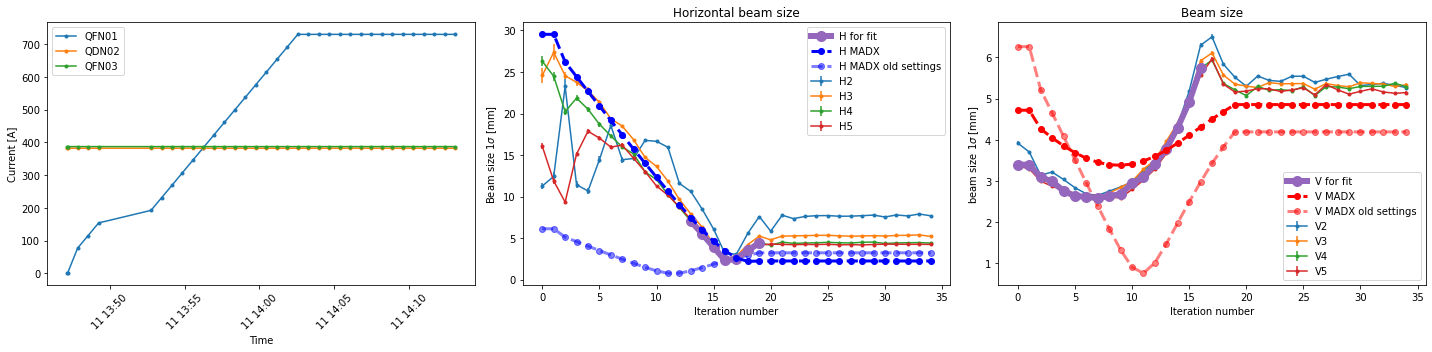

In [44]:
start_path = "/afs/cern.ch/user/e/eljohnso/Desktop/quad-scan-east"
end_path = "quad_scan_east_dump_data"
filename = filename_list[1]


infile = open(end_path+"/"+filename+"/"+filename+".p", 'rb')
loaded_pickle = pickle.load(infile)

timestamp_list = loaded_pickle[0]

acquisition = loaded_pickle[1]["F61D.BTV010/Acquisition"]
    
fig, ax = plt.subplots(1,3, figsize = (20,5), tight_layout=True)

###### PLOT CURRENT ######

qfn01_current = loaded_pickle[3]['F61.QFN01/MEAS.PULSE#VALUE']
qdn02_current = loaded_pickle[3]['F61.QDN02/MEAS.PULSE#VALUE']
qfn03_current = loaded_pickle[3]['F61.QFN03/MEAS.PULSE#VALUE']

ax[0].plot(timestamp_list, qfn01_current, marker = "o", markersize=3, label = "QFN01")
ax[0].plot(timestamp_list, qdn02_current, marker = "o", markersize=3, label = "QDN02")
ax[0].plot(timestamp_list, qfn03_current, marker = "o", markersize=3, label = "QFN03")

ax[0].tick_params('x', labelrotation=45)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Current [A]")
ax[0].legend()

###### SELECT HORIZONTAL DATA ######
range_shots = [13,len(acquisition)-15]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))

H_sigma_list = []

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)
    
    ax[1].errorbar(x_axis, H_sigma_list_i, yerr = H_err_sigma_list_i, marker = "o", markersize=3, label = f"H{acq_number}")
    
    H_sigma_list.append(H_sigma_list_i)
   


d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_H': H_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_H = pd.DataFrame(data=d)
master_df_H = master_df_H.append(df_H, ignore_index=True)

ax[1].plot(x_axis[range_shots[0]:range_shots[1]:], df_H.sigma_H, marker="o", markersize=10, linewidth=6, label = f"H for fit", zorder=99)
ax[1].legend()
ax[1].set_xlabel("Iteration number")
ax[1].set_ylabel(f"Beam size 1$\sigma$ [mm]")
ax[1].set_title("Horizontal beam size")

###### SELECT VERTICAL DATA ######
range_shots = [0,len(acquisition)-18]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))


V_sigma_list = []

for acq_number in [2,3,4,5]:

    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)
    
    ax[2].errorbar(x_axis, V_sigma_list_i, yerr = V_err_sigma_list_i, marker = "o", markersize=3, label = f"V{acq_number}")
       
    V_sigma_list.append(V_sigma_list_i)
   
d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_V': V_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_V = pd.DataFrame(data=d)
master_df_V = master_df_V.append(df_V, ignore_index=True)

ax[2].plot(x_axis[range_shots[0]:range_shots[1]:], df_V.sigma_V, marker="o", markersize=10, linewidth=6, label = f"V for fit", zorder=99)

ax[2].legend()
ax[2].set_xlabel("Iteration number")
ax[2].set_ylabel(f"beam size 1$\sigma$ [mm]")
ax[2].set_title("Beam size")

#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"


H_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    
V_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

ax[1].plot(x_axis, np.array(H_sigma_madx)*1000, color = "b", zorder=100, linestyle = "--", marker = "o", linewidth=3, label = "H MADX")
ax[2].plot(x_axis, np.array(V_sigma_madx)*1000, color = "r", zorder=100, linestyle = "--", marker = "o", linewidth=3, label = "V MADX")



### WITH CODILOG INITIAL CONDITIONS ###
ex = exn0/(beta*gamma)
ey = eyn0/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)

btv="f61.btv010"

H_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx00, bety=bety00, alfx=alfx00, alfy=alfy00, Dx=Dx00, Dy=Dy00, Dpx=Dpx00, Dpy=Dpy00).dframe()

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    
V_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx00, bety=bety00, alfx=alfx00, alfy=alfy00, Dx=Dx00, Dy=Dy00, Dpx=Dpx00, Dpy=Dpy00).dframe()

    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

ax[1].plot(x_axis, np.array(H_sigma_madx)*1000, color = "b",  alpha=0.5, linestyle = "--", marker = "o", linewidth=3, label = "H MADX old settings")
ax[2].plot(x_axis, np.array(V_sigma_madx)*1000, color = "r", alpha=0.5, linestyle = "--", marker = "o", linewidth=3, label = "V MADX old settings")

ax[1].legend()
ax[2].legend()
fig.savefig("fig/"+str(filename)+".png", facecolor='white', transparent=False, dpi=150, bbox_inches='tight');

# Third measurements

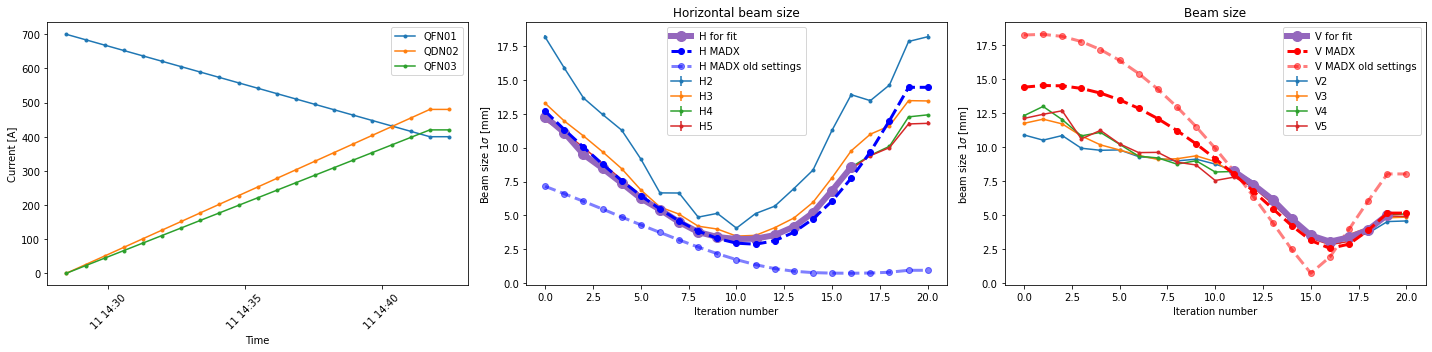

In [45]:
start_path = "/afs/cern.ch/user/e/eljohnso/Desktop/quad-scan-east"
end_path = "quad_scan_east_dump_data"
filename = filename_list[2]


infile = open(end_path+"/"+filename+"/"+filename+".p", 'rb')
loaded_pickle = pickle.load(infile)

timestamp_list = loaded_pickle[0]

acquisition = loaded_pickle[1]["F61D.BTV010/Acquisition"]
    
fig, ax = plt.subplots(1,3, figsize = (20,5), tight_layout=True)

###### PLOT CURRENT ######

qfn01_current = loaded_pickle[3]['F61.QFN01/MEAS.PULSE#VALUE']
qdn02_current = loaded_pickle[3]['F61.QDN02/MEAS.PULSE#VALUE']
qfn03_current = loaded_pickle[3]['F61.QFN03/MEAS.PULSE#VALUE']

ax[0].plot(timestamp_list, qfn01_current, marker = "o", markersize=3, label = "QFN01")
ax[0].plot(timestamp_list, qdn02_current, marker = "o", markersize=3, label = "QDN02")
ax[0].plot(timestamp_list, qfn03_current, marker = "o", markersize=3, label = "QFN03")

ax[0].tick_params('x', labelrotation=45)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Current [A]")
ax[0].legend()

###### SELECT HORIZONTAL DATA ######
range_shots = [0,len(acquisition)-4]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))

H_sigma_list = []

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)
    
    ax[1].errorbar(x_axis, H_sigma_list_i, yerr = H_err_sigma_list_i, marker = "o", markersize=3, label = f"H{acq_number}")
    
    H_sigma_list.append(H_sigma_list_i)
   


d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_H': H_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_H = pd.DataFrame(data=d)
master_df_H = master_df_H.append(df_H, ignore_index=True)

ax[1].plot(x_axis[range_shots[0]:range_shots[1]:], df_H.sigma_H, marker="o", markersize=10, linewidth=6, label = f"H for fit", zorder=99)
ax[1].legend()
ax[1].set_xlabel("Iteration number")
ax[1].set_ylabel(f"Beam size 1$\sigma$ [mm]")
ax[1].set_title("Horizontal beam size")

###### SELECT VERTICAL DATA ######
range_shots = [11,len(acquisition)-1]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))


V_sigma_list = []

for acq_number in [2,3,4,5]:

    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)
    
    ax[2].errorbar(x_axis, V_sigma_list_i, yerr = V_err_sigma_list_i, marker = "o", markersize=3, label = f"V{acq_number}")
       
    V_sigma_list.append(V_sigma_list_i)
   
d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_V': V_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_V = pd.DataFrame(data=d)
master_df_V = master_df_V.append(df_V, ignore_index=True)

ax[2].plot(x_axis[range_shots[0]:range_shots[1]:], df_V.sigma_V, marker="o", markersize=10, linewidth=6, label = f"V for fit", zorder=99)

ax[2].legend()
ax[2].set_xlabel("Iteration number")
ax[2].set_ylabel(f"beam size 1$\sigma$ [mm]")
ax[2].set_title("Beam size")

#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"


H_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    
V_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

ax[1].plot(x_axis, np.array(H_sigma_madx)*1000, color = "b", zorder=100, linestyle = "--", marker = "o", linewidth=3, label = "H MADX")
ax[2].plot(x_axis, np.array(V_sigma_madx)*1000, color = "r", zorder=100, linestyle = "--", marker = "o", linewidth=3, label = "V MADX")



### WITH CODILOG INITIAL CONDITIONS ###
ex = exn0/(beta*gamma)
ey = eyn0/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)

btv="f61.btv010"

H_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx00, bety=bety00, alfx=alfx00, alfy=alfy00, Dx=Dx00, Dy=Dy00, Dpx=Dpx00, Dpy=Dpy00).dframe()

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    
V_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx00, bety=bety00, alfx=alfx00, alfy=alfy00, Dx=Dx00, Dy=Dy00, Dpx=Dpx00, Dpy=Dpy00).dframe()

    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

ax[1].plot(x_axis, np.array(H_sigma_madx)*1000, color = "b", alpha=0.5, linestyle = "--", marker = "o", linewidth=3, label = "H MADX old settings")
ax[2].plot(x_axis, np.array(V_sigma_madx)*1000, color = "r", alpha=0.5, linestyle = "--", marker = "o", linewidth=3, label = "V MADX old settings")

ax[1].legend()
ax[2].legend()
fig.savefig("fig/"+str(filename)+".png", facecolor='white', transparent=False, dpi=150, bbox_inches='tight');

# Fourth measurement

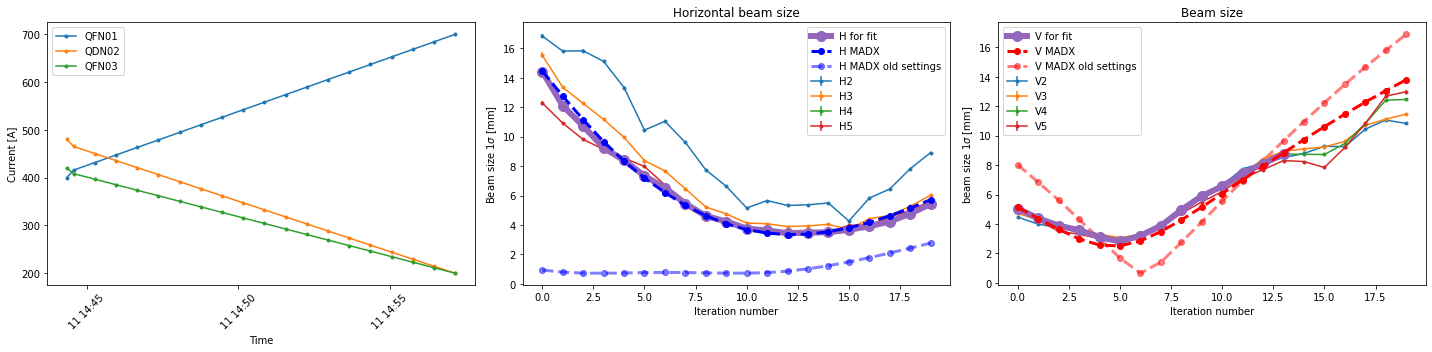

In [46]:
start_path = "/afs/cern.ch/user/e/eljohnso/Desktop/quad-scan-east"
end_path = "quad_scan_east_dump_data"
filename = filename_list[3]


infile = open(end_path+"/"+filename+"/"+filename+".p", 'rb')
loaded_pickle = pickle.load(infile)

timestamp_list = loaded_pickle[0]

acquisition = loaded_pickle[1]["F61D.BTV010/Acquisition"]
    
fig, ax = plt.subplots(1,3, figsize = (20,5), tight_layout=True)

###### PLOT CURRENT ######

qfn01_current = loaded_pickle[3]['F61.QFN01/MEAS.PULSE#VALUE']
qdn02_current = loaded_pickle[3]['F61.QDN02/MEAS.PULSE#VALUE']
qfn03_current = loaded_pickle[3]['F61.QFN03/MEAS.PULSE#VALUE']

ax[0].plot(timestamp_list, qfn01_current, marker = "o", markersize=3, label = "QFN01")
ax[0].plot(timestamp_list, qdn02_current, marker = "o", markersize=3, label = "QDN02")
ax[0].plot(timestamp_list, qfn03_current, marker = "o", markersize=3, label = "QFN03")

ax[0].tick_params('x', labelrotation=45)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Current [A]")
ax[0].legend()

###### SELECT HORIZONTAL DATA ######
range_shots = [0,len(acquisition)-0]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))

H_sigma_list = []

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)
    
    ax[1].errorbar(x_axis, H_sigma_list_i, yerr = H_err_sigma_list_i, marker = "o", markersize=3, label = f"H{acq_number}")
    
    H_sigma_list.append(H_sigma_list_i)
   


d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_H': H_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_H = pd.DataFrame(data=d)
master_df_H = master_df_H.append(df_H, ignore_index=True)

ax[1].plot(x_axis[range_shots[0]:range_shots[1]:], df_H.sigma_H, marker="o", markersize=10, linewidth=6, label = f"H for fit", zorder=99)
ax[1].legend()
ax[1].set_xlabel("Iteration number")
ax[1].set_ylabel(f"Beam size 1$\sigma$ [mm]")
ax[1].set_title("Horizontal beam size")

###### SELECT VERTICAL DATA ######
range_shots = [0,len(acquisition)-6]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))


V_sigma_list = []

for acq_number in [2,3,4,5]:

    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)
    
    ax[2].errorbar(x_axis, V_sigma_list_i, yerr = V_err_sigma_list_i, marker = "o", markersize=3, label = f"V{acq_number}")
       
    V_sigma_list.append(V_sigma_list_i)
   
d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_V': V_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_V = pd.DataFrame(data=d)
master_df_V = master_df_V.append(df_V, ignore_index=True)

ax[2].plot(x_axis[range_shots[0]:range_shots[1]:], df_V.sigma_V, marker="o", markersize=10, linewidth=6, label = f"V for fit", zorder=99)

ax[2].legend()
ax[2].set_xlabel("Iteration number")
ax[2].set_ylabel(f"beam size 1$\sigma$ [mm]")
ax[2].set_title("Beam size")

#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"


H_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    
V_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

ax[1].plot(x_axis, np.array(H_sigma_madx)*1000, color = "b", zorder=100, linestyle = "--", marker = "o", linewidth=3, label = "H MADX")
ax[2].plot(x_axis, np.array(V_sigma_madx)*1000, color = "r", zorder=100, linestyle = "--", marker = "o", linewidth=3, label = "V MADX")



### WITH CODILOG INITIAL CONDITIONS ###
ex = exn0/(beta*gamma)
ey = eyn0/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)

btv="f61.btv010"

H_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx00, bety=bety00, alfx=alfx00, alfy=alfy00, Dx=Dx00, Dy=Dy00, Dpx=Dpx00, Dpy=Dpy00).dframe()

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    
V_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx00, bety=bety00, alfx=alfx00, alfy=alfy00, Dx=Dx00, Dy=Dy00, Dpx=Dpx00, Dpy=Dpy00).dframe()

    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

ax[1].plot(x_axis, np.array(H_sigma_madx)*1000, color = "b", alpha=0.5, linestyle = "--", marker = "o", linewidth=3, label = "H MADX old settings")
ax[2].plot(x_axis, np.array(V_sigma_madx)*1000, color = "r", alpha=0.5, linestyle = "--", marker = "o", linewidth=3, label = "V MADX old settings")

ax[1].legend()
ax[2].legend()
fig.savefig("fig/"+str(filename)+".png", facecolor='white', transparent=False, dpi=150, bbox_inches='tight');

# Fifth measurement

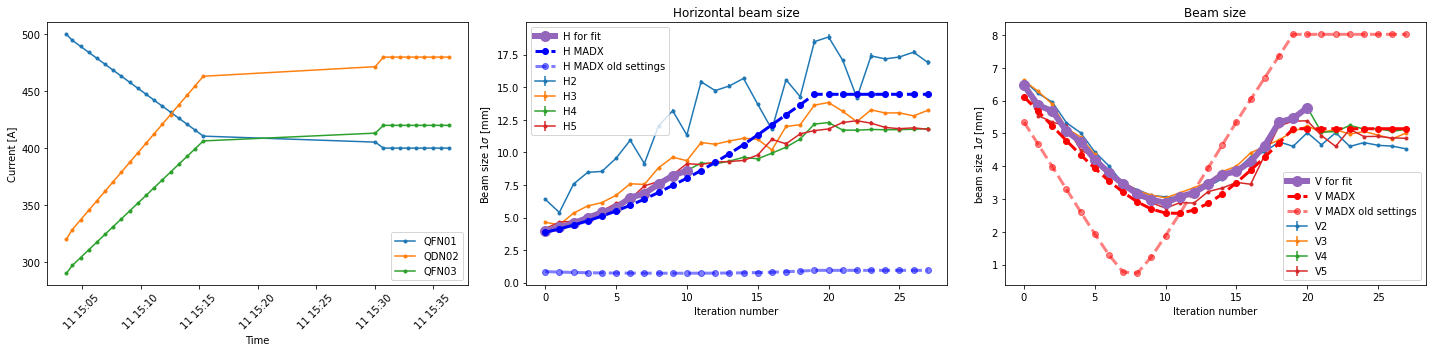

In [47]:
start_path = "/afs/cern.ch/user/e/eljohnso/Desktop/quad-scan-east"
end_path = "quad_scan_east_dump_data"
filename = filename_list[4]


infile = open(end_path+"/"+filename+"/"+filename+".p", 'rb')
loaded_pickle = pickle.load(infile)

timestamp_list = loaded_pickle[0]

acquisition = loaded_pickle[1]["F61D.BTV010/Acquisition"]
    
fig, ax = plt.subplots(1,3, figsize = (20,5), tight_layout=True)

###### PLOT CURRENT ######

qfn01_current = loaded_pickle[3]['F61.QFN01/MEAS.PULSE#VALUE']
qdn02_current = loaded_pickle[3]['F61.QDN02/MEAS.PULSE#VALUE']
qfn03_current = loaded_pickle[3]['F61.QFN03/MEAS.PULSE#VALUE']

ax[0].plot(timestamp_list, qfn01_current, marker = "o", markersize=3, label = "QFN01")
ax[0].plot(timestamp_list, qdn02_current, marker = "o", markersize=3, label = "QDN02")
ax[0].plot(timestamp_list, qfn03_current, marker = "o", markersize=3, label = "QFN03")

ax[0].tick_params('x', labelrotation=45)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Current [A]")
ax[0].legend()

###### SELECT HORIZONTAL DATA ######
range_shots = [0,len(acquisition)-17]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))

H_sigma_list = []

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)
    
    ax[1].errorbar(x_axis, H_sigma_list_i, yerr = H_err_sigma_list_i, marker = "o", markersize=3, label = f"H{acq_number}")
    
    H_sigma_list.append(H_sigma_list_i)
   


d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_H': H_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_H = pd.DataFrame(data=d)
master_df_H = master_df_H.append(df_H, ignore_index=True)

ax[1].plot(x_axis[range_shots[0]:range_shots[1]:], df_H.sigma_H, marker="o", markersize=10, linewidth=6, label = f"H for fit", zorder=99)
ax[1].legend()
ax[1].set_xlabel("Iteration number")
ax[1].set_ylabel(f"Beam size 1$\sigma$ [mm]")
ax[1].set_title("Horizontal beam size")

###### SELECT VERTICAL DATA ######
range_shots = [0,len(acquisition)-7]
x_axis = np.linspace(0,len(acquisition)-1,len(acquisition))


V_sigma_list = []

for acq_number in [2,3,4,5]:

    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)
    
    ax[2].errorbar(x_axis, V_sigma_list_i, yerr = V_err_sigma_list_i, marker = "o", markersize=3, label = f"V{acq_number}")
       
    V_sigma_list.append(V_sigma_list_i)
   
d = {'qfn01_current': qfn01_current[range_shots[0]:range_shots[1]:],
     'qdn02_current': qdn02_current[range_shots[0]:range_shots[1]:],
     'qfn03_current': qfn03_current[range_shots[0]:range_shots[1]:],
     'sigma_V': V_sigma_list[2][range_shots[0]:range_shots[1]:], # Here is where you choose which acquisition to pick
    }
df_V = pd.DataFrame(data=d)
master_df_V = master_df_V.append(df_V, ignore_index=True)

ax[2].plot(x_axis[range_shots[0]:range_shots[1]:], df_V.sigma_V, marker="o", markersize=10, linewidth=6, label = f"V for fit", zorder=99)

ax[2].legend()
ax[2].set_xlabel("Iteration number")
ax[2].set_ylabel(f"beam size 1$\sigma$ [mm]")
ax[2].set_title("Beam size")

#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"


H_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    
V_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

ax[1].plot(x_axis, np.array(H_sigma_madx)*1000, color = "b", zorder=100, linestyle = "--", marker = "o", linewidth=3, label = "H MADX")
ax[2].plot(x_axis, np.array(V_sigma_madx)*1000, color = "r", zorder=100, linestyle = "--", marker = "o", linewidth=3, label = "V MADX")



### WITH CODILOG INITIAL CONDITIONS ###
ex = exn0/(beta*gamma)
ey = eyn0/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)

btv="f61.btv010"

H_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx00, bety=bety00, alfx=alfx00, alfy=alfy00, Dx=Dx00, Dy=Dy00, Dpx=Dpx00, Dpy=Dpy00).dframe()

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    
V_sigma_madx = []
for i in range(len(qfn01_current)):
    quad_current["QFN01"] = qfn01_current[i]
    quad_current["QDN02"] = qdn02_current[i]
    quad_current["QFN03"] = qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx00, bety=bety00, alfx=alfx00, alfy=alfy00, Dx=Dx00, Dy=Dy00, Dpx=Dpx00, Dpy=Dpy00).dframe()

    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

ax[1].plot(x_axis, np.array(H_sigma_madx)*1000, color = "b", alpha=0.5, linestyle = "--", marker = "o", linewidth=3, label = "H MADX old settings")
ax[2].plot(x_axis, np.array(V_sigma_madx)*1000, color = "r", alpha=0.5, linestyle = "--", marker = "o", linewidth=3, label = "V MADX old settings")

ax[1].legend()
ax[2].legend()
fig.savefig("fig/"+str(filename)+".png", facecolor='white', transparent=False, dpi=150, bbox_inches='tight');

# Compare with MADX

In [55]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"


H_sigma_madx = []
for i in range(len(master_df_H)):
    quad_current["QFN01"] = master_df_H.qfn01_current[i]
    quad_current["QDN02"] = master_df_H.qdn02_current[i]
    quad_current["QFN03"] = master_df_H.qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    
V_sigma_madx = []
for i in range(len(master_df_V)):
    quad_current["QFN01"] = master_df_V.qfn01_current[i]
    quad_current["QDN02"] = master_df_V.qdn02_current[i]
    quad_current["QFN03"] = master_df_V.qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

exn0=1.5e-6
eyn0=1.5e-6
ex = exn0/(beta*gamma)
ey = eyn0/(beta*gamma)
madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
    
H_sigma_madx0 = []
for i in range(len(master_df_H)):
    quad_current["QFN01"] = master_df_H.qfn01_current[i]
    quad_current["QDN02"] = master_df_H.qdn02_current[i]
    quad_current["QFN03"] = master_df_H.qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx00, bety=bety00, alfx=alfx00, alfy=alfy00, Dx=Dx00, Dy=Dy00, Dpx=Dpx00, Dpy=Dpy00).dframe()

    H_sigma_madx0.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    
V_sigma_madx0 = []
for i in range(len(master_df_V)):
    quad_current["QFN01"] = master_df_V.qfn01_current[i]
    quad_current["QDN02"] = master_df_V.qdn02_current[i]
    quad_current["QFN03"] = master_df_V.qfn03_current[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx00, bety=bety00, alfx=alfx00, alfy=alfy00, Dx=Dx00, Dy=Dy00, Dpx=Dpx00, Dpy=Dpy00).dframe()

    V_sigma_madx0.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

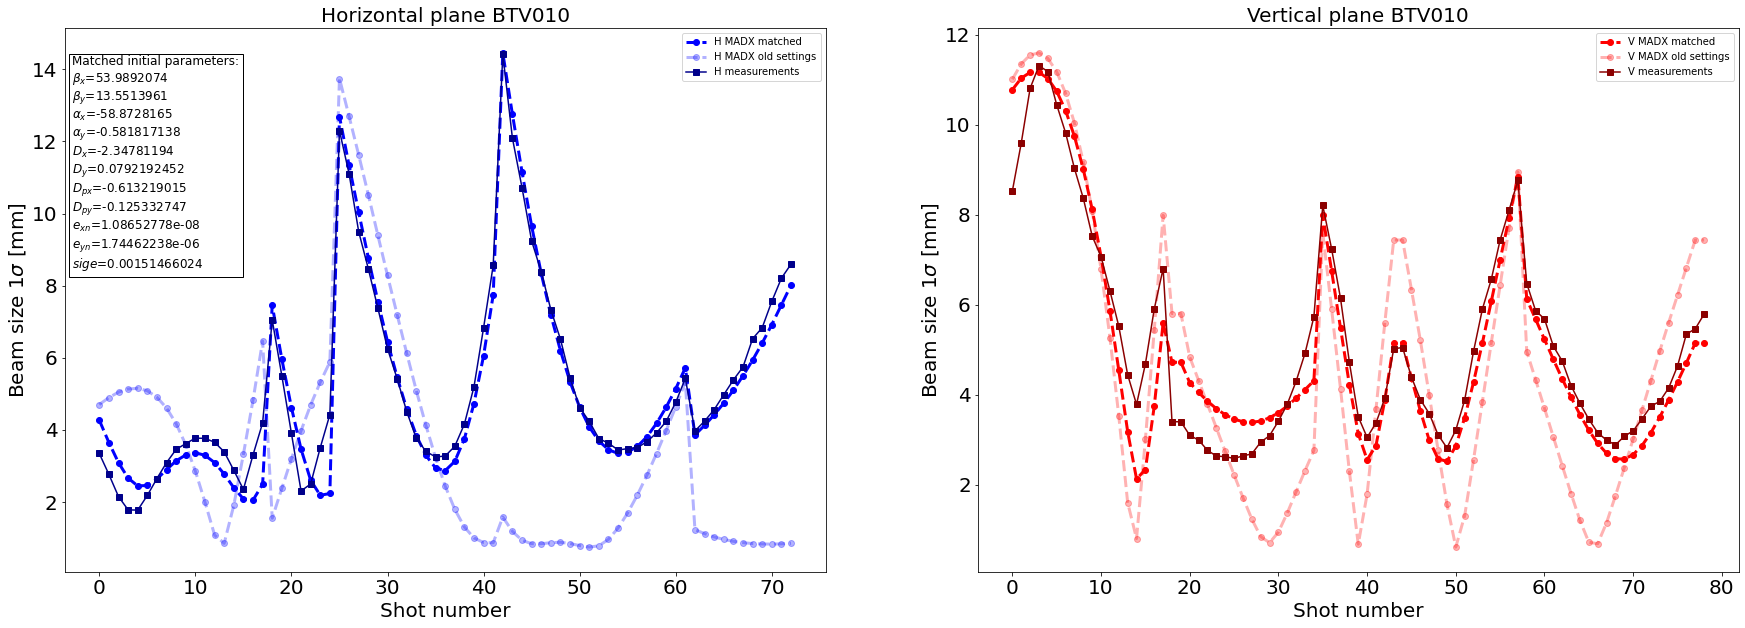

In [56]:
fig, ax = plt.subplots(1,2, figsize=(30,10))

### Horizontal ###
x_axis_total_H = np.linspace(0,len(master_df_H.sigma_H)-1, len(master_df_H.sigma_H))
ax[0].plot(x_axis_total_H, np.array(H_sigma_madx)*1000, color = "b", linestyle = "--", marker = "o", linewidth=3, label = "H MADX matched")
ax[0].plot(x_axis_total_H, np.array(H_sigma_madx0)*1000, color = "b", alpha=0.3, linestyle = "--", marker = "o", linewidth=3, label = "H MADX old settings")
ax[0].plot(x_axis_total_H, master_df_H.sigma_H, color = "darkblue", marker = "s", label = "H measurements")

ax[0].legend()
ax[0].set_xlabel("Shot number", fontsize=20)
ax[0].set_ylabel(f"Beam size 1$\sigma$ [mm]", fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].tick_params(axis='both', which='minor', labelsize=18)
ax[0].set_title("Horizontal plane BTV010", fontsize = 20)

### Vertical ###
x_axis_total_V = np.linspace(0,len(master_df_V.sigma_V)-1, len(master_df_V.sigma_V))
ax[1].plot(x_axis_total_V, np.array(V_sigma_madx)*1000, color = "r", linestyle = "--", marker = "o", linewidth=3, label = "V MADX matched")
ax[1].plot(x_axis_total_V, np.array(V_sigma_madx0)*1000, color = "r", alpha=0.3, linestyle = "--", marker = "o", linewidth=3, label = "V MADX old settings")
ax[1].plot(x_axis_total_V, master_df_V.sigma_V, color = "darkred", marker = "s", label = "V measurements")

ax[1].legend()
ax[1].set_xlabel("Shot number", fontsize=20)
ax[1].set_ylabel(f"Beam size 1$\sigma$ [mm]", fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='minor', labelsize=18)
ax[1].set_title("Vertical plane BTV010", fontsize = 20)

# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$\beta_{x}$='+str(betx0),
    r'$\beta_{y}$='+str(bety0),
    r'$\alpha_{x}$='+str(alfx0),
    r'$\alpha_{y}$='+str(alfy0),
    r'$D_{x}$='+str(Dx0),
    r'$D_{y}$='+str(Dy0),
    r'$D_{px}$='+str(Dpx0),
    r'$D_{py}$='+str(Dpy0),
    r'$e_{xn}$='+str(exn),
    r'$e_{yn}$='+str(eyn),
    r'$sige$='+str(sige),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=1.0)

# place a text box in upper left in axes coords
ax[0].text(0.01, 0.95, textstr, transform=ax[0].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
fig.savefig("fig/all_measurement_comparison.png", facecolor='white', transparent=False, dpi=150, bbox_inches='tight');